![CAO Logo](https://upload.wikimedia.org/wikipedia/commons/5/51/Central_Applications_Office.png)

# CAO Points Analysis

This notebook demonstrates how to gather and analyse CAO points data for level 8 courses over the last three years.

The first part will discuss the various formats in which the points data is stored on the CAO website, and how to download these from the website using Python. Additionally, guidelines will be given on converting the points data to Pandas dataframes, which can then be used for further analysis.

The second part will discuss the analysis that was performed on the resulting Pandas dataframes, with a particular focus on the following techniques:

1. Merging the three distinct dataframes together for analysis on the full dataset
2. Changing the shape of the dataset to get all three years on the same column for Seaborn plots
3. Sorting/grouping the dataset to find maximum and minimum values for variables (e.g. course type)

## Research Questions

The following research questions will be used to organize the findings:

1. What is the overall distribution of level 8 points values, and how has this changed over the past three years?
2. What are the most popular areas of study (i.e. the areas in which the most courses are offered), and have points increased or decreased for these over the past three years?
3. How does the distribution of points differ between Universities and Institutes of Technology (ITs)?
4. What were the highest/lowest point courses each year?
5. For the highest/lowest points of 2019, did these increase or decrease in popularity in 2020/21?

This notebook will present the code required to answer these questions, the resulting data/plots, and discuss the results.

## Part 1: Points Data

### 2021

The 2021 points data is stored as a webpage at the below address:

http://www2.cao.ie/points/l8.php

In order to convert this data into a format compatible with the Pandas dataframe, the following steps are required:

1. Retrieve the data
2. Back up the data as of the current/date and time and save it as a html file
3. Create a regex pattern to detect course/points information only and filter out unnecessary detail
4. Write all lines of the original webpage that match the regex statement to a CSV file
5. Convert the compiled points data to a Pandas dataframe
6. Change the R1/R2 points columns to numeric to facilitate further analysis. 

#### Part 1: Retrieve and Back Up Data

The CAO course data for 2021 was, at the time I started this project, available only in HTML format on the CAO website. In November the data was made available in an Excel format. However I have decided to keep the HTML format in this notebook to illustrate how data can be converted directly from a website to a format compatible with Pandas.

The data is obtained from the CAO website using the requests module, which allows you to send a HTTP request to a webpage. The HTTP request then returns a **response** object, which contains the content, encoding and status of the webpage.

The webpage content must then be backed up at the time/date the HTTP request was made. This is done by constructing a filepath including the current system date and time, and writing the text contents to a HTML file. 

Note that an encoding parameter must be passed to convert the webpage data to readable text. According to the web server, the character set used to encode this website is ISO 8859-1 (as seen in below code), this cannot be used as the encoding parameter due to one character that is incompatible with this standard.

In [1]:
import re
import urllib
import requests as rq
import datetime as dt
import os
import pandas as pd
from urllib.request import urlopen

response = urlopen('http://www2.cao.ie/points/l8.php')
charset = response.headers.get_content_charset()
print(charset)

iso-8859-1


Instead, the CP1252 standard must be used to decode the webpage, as this supports the character (x96) that is not compatible with ISO 8859-1.

The code to decode and back up the data is given below. 

In [2]:
#Getting current date and time so unique, up to date version of site is saved each time code is run
#Note that underscores are being used instead of slashes, as slashes will cause issues when generating the file path

timenow = dt.datetime.now()
nowstrng = timenow.strftime('%Y%m%d_%H%M%S')

#Getting current directory to pass to filepath variable
currentpath = os.getcwd()

#Getting data from CAO site
resp = rq.get('http://www2.cao.ie/points/l8.php')

#Constructing filepath
filepath  = currentpath + '\\' + 'Points_Data'+ '\\' + 'cao2021'+ nowstrng + '.html'
csvfilepath = currentpath + '\\' +'Points_Data'+ '\\'+ 'cao2021' + nowstrng + '.csv'

#Changing encoding from iso-8859-1 to cp1252, one line uses an x96 character (-) which is not supported in iso-8859-1. 
#If encoding is not changed the file won't be decoded
original_encoding = resp.encoding
resp.encoding = 'cp1252'

#Writing html text to file so original format is stored on repository
with open(filepath, "w") as f:
    f.write(resp.text)

print("Data saved to {}".format(filepath))

Data saved to C:\Users\Owner\Desktop\Fundamentals-of-Data-Analysis-21-Assessment\Points_Data\cao202120220102_160439.html


#### Part 2: Extract Points Data and Export to CSV

Below is a screenshot showing the format of the 2021 points webpage. 

##### Figure 1: CAO Website Points 2021

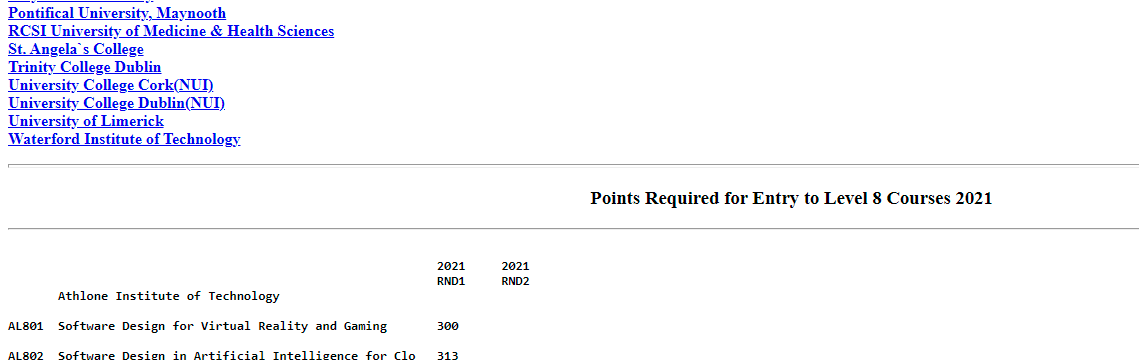

As seen in the screenshot, several elements of the webpage are not required for our purposes, such as the title and links to certain areas of the page.

We can also see that the points data follows a specific format. First, the course code is listed, then the name, then the Round 1 and 2 points for that course. Therefore, constructing a regex statement that captures data in this format and applying it to all lines in the webpage should allow us to only extract lines relating to courses and points.

The code to extract the data and back it up to a csv file is given below. First a regex sequence is defined. A regex, or regular expression, is a sequence of characters which form a search pattern. This pattern then can be used to check if a string matches this pattern. 

To apply regular expressions to our stored webpage, the regex (re) inbuilt Python module is used. In conjunction with a regex sequence, we will use the compile method to store  

This expression consists of two alphabetic characters (representing a college, e.g. CK for UCC), 3 numerical characters (the course code), and any detail following the course ID such as title and round 1/2 points.

In [3]:
#Regex Statement to identify lines containing course data
#First section finds course code - 1 letter and three numbers
#Next section retrieves all other info - course name, points etc
coursematch = re.compile(r'([A-Z]{2}[0-9]{3})(.*)')

#Check to ensure all lines are processed
total_lines  = 0

with open (csvfilepath,"w") as f:
    for line in  resp.iter_lines ():
        dline = line.decode('cp1252')
        if coursematch.fullmatch(dline):
            # Add one to the lines counter.
            total_lines = total_lines + 1
            # The course code.
            course_code = dline[:5]
            # The course title - char 7 is the start of the title section, char 57 is where the longest title ends
            # strip is to remove white space at the beginning and end of each line
            course_title = dline[7:57].strip()
            # Round one points.
            course_points = re.split(' +', dline[60:])

            #Splitting points into round one and two, where r2 points exist
            if len(course_points) != 2:
                course_points = course_points[:2]
            # Join the fields using a comma.
            linesplit = [course_code, course_title, course_points[0], course_points[1]]
            # Rejoin the substrings with commas in between.
            f.write(','.join(linesplit) + '\n')

# Print the total number of processed lines.
print(f"Total number of lines is {total_lines}.")

Total number of lines is 949.


#### Part 3: Export to Pandas Dataframe

Once the course data has been extracted and backed up, it must be converted to a Pandas dataframe to faciliate analysis.

To calculate descriptive statistics on the points data, such as mean/standard deviation/max/min, the dataframe columns containing the R1 and R2 points figures must be converted to a numeric data type. To do this, first any non-numeric characters (e.g. #) are removed, then the columns are converted to numeric (type int). These characters in the points columns are used to give further information on the course, e.g. not every applicant meeting the points requirement was accepted. These datapoints are considered separately later in the notebook.

In [4]:
headers = ["Course_Code", "Course_Name", "R1_Points21", "R2_Points21"]

pointsData21 = pd.read_csv (csvfilepath, sep = ',', names = headers, encoding = 'cp1252')

#Keeping a version of the dataframe with the # and * characters to look at these courses separately
pointsData21_with_chars = pointsData21

#Replacing all non-numeric chars and words with nothing, so I can convert these columns to numeric
pointsData21['R1_Points21'] = pointsData21['R1_Points21'].str.replace(r'[^0-9]+', '', regex = True)
pointsData21['R2_Points21'] = pointsData21['R2_Points21'].str.replace(r'[^0-9]+','', regex = True)

pointsData21['R1_Points21'] = pointsData21['R1_Points21'].str.replace(r'[a-zA-Z]+', '', regex = True)
pointsData21['R2_Points21'] = pointsData21['R2_Points21'].str.replace(r'[a-zA-Z]+', '', regex = True)

#Changing points columns to numeric
pointsData21[["R1_Points21"]] = pointsData21[["R1_Points21"]].apply(pd.to_numeric)
pointsData21[["R2_Points21"]] = pointsData21[["R2_Points21"]].apply(pd.to_numeric)

pointsData21.to_csv(csvfilepath)

The final step is to print the first 10 columns of the dataframe generated as a sanity check. 

In [5]:
#Printing first 10 columns of dataframe to ensure it makes sense

with pd.option_context('expand_frame_repr', False):
    print(pointsData21[["Course_Code", "Course_Name", "R1_Points21", "R2_Points21"]].head(n = 10))

  Course_Code                                        Course_Name  R1_Points21  R2_Points21
0       AL801     Software Design for Virtual Reality and Gaming        300.0          NaN
1       AL802  Software Design in Artificial Intelligence for...        313.0          NaN
2       AL803  Software Design for Mobile Apps and Connected ...        350.0          NaN
3       AL805    Computer Engineering for Network Infrastructure        321.0          NaN
4       AL810                                 Quantity Surveying        328.0          NaN
5       AL811                                  Civil Engineering          NaN          NaN
6       AL820                 Mechanical and Polymer Engineering        327.0          NaN
7       AL830                                    General Nursing        451.0        444.0
8       AL832                              Mental Health Nursing        440.0        431.0
9       AL835                                       Pharmacology        356.0          NaN


#### 2020 Points

The steps in retrieving the 2020 points data are similar, except the format on the CAO website is Excel rather than HTML.

To extract the Excel data, an inbuilt pandas function is used called pd.read_excel(), to which the address of the Excel file on the CAO website is passed as an argument.

In the version on the CAO website, the first 9 rows contain instructions for interpreting the file, as seen below. Therefore, when reading the CAO file, only lines from Row 10 onwards wil be used to generate the dataframe.

##### Figure 2: 2020 Points Screen Capture
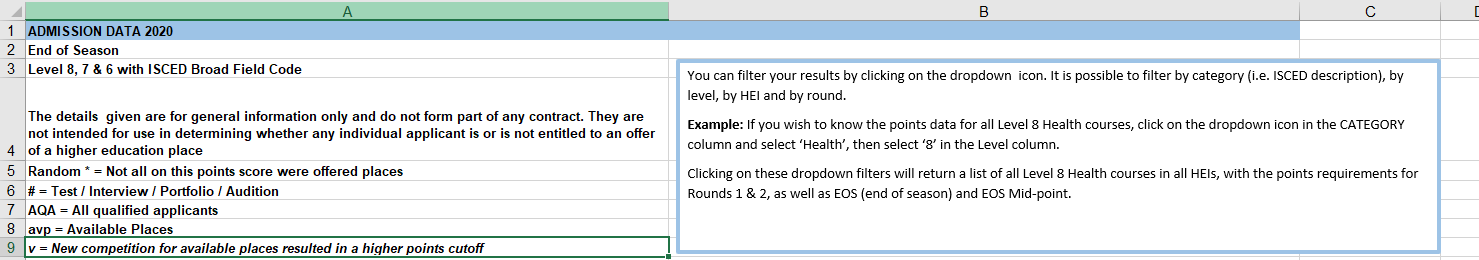

The code for generating the backup file destinations and reading the 2020 points data into a Pandas dataframe is given below. 

The last line is a check to ensure all the rows were outputted to the dataframe - excluding the instructions and header column, the file consisted of 1464 rows. 

In [6]:
timenow = dt.datetime.now()
nowstrng = timenow.strftime('%Y%m%d_%H%M%S')

#Get current file path to construct backup file destination paths
currentpath = os.getcwd()

#Constructing filepath
filepath  = currentpath + '\\' + 'Points_Data' + '\\' +'cao2020'+ nowstrng + '.html'
csvfilepath = currentpath + '\\' + 'Points_Data' + '\\' +'cao2020' + nowstrng + '.csv'
pandasfilepath = currentpath + '\\' + 'Points_Data' + '\\' +'cao2020_Pandasdf' + nowstrng + '.csv'

df2020 = pd.read_excel('http://www2.cao.ie/points/CAOPointsCharts2020.xlsx', header = 10, dtype = str)
df2020.to_csv(csvfilepath, encoding = 'utf-8', index = False)
print("Total Rows Processed : {}".format(len(df2020.index)))

Total Rows Processed : 1464


Once the original dataset is backed up to CSV, we can create a new dataframe with only the variables of interest, as seen in the code below. As with the 2020 points data, the R1/R2 points columns must also be converted to numeric to facilitate further analysis. 

In [7]:
#Only interested in L8 courses so filtering out other levels
points2020 = df2020[df2020["LEVEL"] == "8"]

#Creating a new version of the dataframe with only the columns I'll use for analysis
points2020 = df2020.filter(['COURSE TITLE', 'COURSE CODE2', 'R1 POINTS', 'R2 POINTS', 'CATEGORY (i.e.ISCED description)', "HEI"])
points2020.to_csv(pandasfilepath, encoding = 'utf-8', index = False )

# Keeping a version of the dataframe with non-numeric characters to do further analysis on those courses
points2020_with_chars = points2020
points2020_with_chars = points2020.rename(columns = {"COURSE TITLE": "Course Name", "COURSE CODE2": "Course_Code", "R1 POINTS": "R1_Points20", "R2 POINTS": "R2_Points20"})

#Removing all non-numeric chars to get descriptive stats on points
points2020['R1 POINTS'] = points2020['R1 POINTS'].str.replace(r'[^0-9]+', '', regex = True)
points2020['R2 POINTS'] = points2020['R2 POINTS'].str.replace(r'[^0-9]+','', regex = True)

points2020['R1 POINTS'] = points2020['R1 POINTS'].str.replace(r'[a-zA-Z]+', '', regex = True)
points2020['R2 POINTS'] = points2020['R2 POINTS'].str.replace(r'[a-zA-Z]+', '', regex = True)

#Changing some of the names to match the other two years and converting points columns to numeric
points2020 = points2020.rename(columns = {"COURSE TITLE": "Course Name", "COURSE CODE2": "Course_Code", "R1 POINTS": "R1_Points20", "R2 POINTS": "R2_Points20"})
points2020[["R1_Points20"]] = points2020[["R1_Points20"]].apply(pd.to_numeric)
points2020[["R2_Points20"]] = points2020[["R2_Points20"]].apply(pd.to_numeric)

#Sanity Check on DF columns
with pd.option_context('expand_frame_repr', False):
    print(points2020_with_chars[["Course Name", "Course_Code", "R1_Points20", "R2_Points20"]].head(n = 10))

                                         Course Name Course_Code R1_Points20 R2_Points20
0                             International Business       AC120         209         NaN
1                                       Liberal Arts       AC137         252         NaN
2   First Year Art & Design (Common Entry,portfolio)       AD101    #+matric         NaN
3  Graphic Design and Moving Image Design (portfo...       AD102    #+matric         NaN
4  Textile & Surface Design and Jewellery & Objec...       AD103    #+matric         NaN
5  Education & Design or Fine Art (Second Level T...       AD202    #+matric         NaN
6                               Fine Art (portfolio)       AD204    #+matric         NaN
7                         Fashion Design (portfolio)       AD211    #+matric         NaN
8                         Product Design (portfolio)       AD212    #+matric         NaN
9                                     Visual Culture       AD215         377         320


#### 2019 Points

The 2019 points data is in a PDF format. To process the data from this year and convert it to a dataframe, I'm using the Tabula module. 

Tabula allows you to read data in a table format from a PDF file, and convert it to a Pandas dataframe.

[Link to Tabula Docs](https://tabula-py.readthedocs.io/en/latest/)

Before converting the 2019 points to a Pandas dataframe, the latest version of the PDF file on the CAO website must be downloaded and saved to the backup folder. For this, the urllib.request module for opening/reading URLS can be used. 

[Link to Urllib Request Docs](https://docs.python.org/3/library/urllib.request.html#module-urllib.request)

Below is the code that can be used to retrieve the 2019 points data from the CAO website, save the backup PDF file and convert it to a Pandas dataframe. The function download_file takes the web address of the 2019 points data as a parameter, opens the file and saves it locally as a PDF, which is then converted by Tabula to a PDF file. 

In [8]:
import urllib
import urllib.request
import tabula

currentpath = os.getcwd()
timenow = dt.datetime.now()
nowstrng = timenow.strftime('%Y%m%d_%H%M%S')

#Constructing filepaths to backup PDF file and dataframe
pdffilepath = currentpath + '\\' + 'Points_Data' + '\\' +  'cao2019' + nowstrng + '.pdf'
csvfilepath = currentpath  + '\\' + 'Points_Data' + '\\' + 'cao2019' + nowstrng + '.csv'
wcharsfilepath = currentpath  + '\\' + 'Points_Data' + '\\' + 'cao2019_wchars' + nowstrng + '.csv'


#Function that takes a web address as a parameter
#Purpose is to download the data and save it as a PDF file locally
#Then can use Tabula to convert to DF
def download_file(download_url):
    response = urllib.request.urlopen(download_url)
    file = open(pdffilepath, 'wb')
    file.write(response.read())
    file.close()

    #Reading the PDF data and converting it to a dataframe
    #Count is to keep track of rows in dataframe - should have 948
    pointsdf = tabula.read_pdf(pdffilepath, pages = 'all')
    count = 0

    #Extracting only the columns that I'm interested in for further analysis
    colnames = ["Course_Code", "Course Name", "R1_Points19", "R2_Points19"]


    list = []

    for item in pointsdf:
        for info in item.values: 
            list.append(info) 
            count = count + 1
        
        points2019 = pd.DataFrame (list, columns=colnames)
        points2019.to_csv(csvfilepath, encoding = 'utf-8', index = False)
    
    print("Total Lines Processed: {}".format(count))

    return points2019
    

points2019 = download_file(download_url= 'http://www2.cao.ie/points/lvl8_19.pdf')

#Removing any rows that don't have a course code in them - these are the college names only
points2019.dropna(subset = ["Course_Code"], inplace=True)
print("Total Rows Remaining : {}".format(len(points2019.index)))

#Want to preserve version of dataset with chars like # and * so these can be analysed separately
points2019_with_chars = points2019

#Issue with a few of the rows where # + matric was split over the 
#R1 and R2 points columns, fixing this using find and replace
points2019_with_chars ['R1_Points19']  = points2019['R1_Points19'].str.replace("# +mat", "# +matric", regex = False)
points2019_with_chars ['R2_Points19'] = points2019['R2_Points19'].str.replace("ic ", "", regex = False)

points2019_with_chars.to_csv(wcharsfilepath, encoding = 'utf-8', index = False)

#Removing all non-numeric chars so cols can be converted to dataframe format
points2019['R1_Points19'] = points2019['R1_Points19'].str.replace(r'[^0-9]+', '', regex = True)
points2019['R2_Points19'] = points2019['R2_Points19'].str.replace(r'[^0-9]+','', regex = True)

points2019['R1_Points19'] = points2019['R1_Points19'].str.replace(r'[a-zA-Z]+', '', regex = True)
points2019['R2_Points19'] = points2019['R2_Points19'].str.replace(r'[a-zA-Z]+', '', regex = True)


points2019[["R1_Points19"]] = points2019[["R1_Points19"]].apply(pd.to_numeric)
points2019[["R2_Points19"]] = points2019[["R2_Points19"]].apply(pd.to_numeric)

Total Lines Processed: 948
Total Rows Remaining : 914


Finally, the first 10 lines of the dataframe are printed to ensure they are as expected. 

In [9]:
with pd.option_context('expand_frame_repr', False):
    print(points2019_with_chars.head(n = 10))

   Course_Code                                        Course Name  R1_Points19  R2_Points19
1        AL801    Software Design with Virtual Reality and Gaming        304.0          NaN
2        AL802               Software Design with Cloud Computing        301.0          NaN
3        AL803  Software Design with Mobile Apps and Connected...        309.0          NaN
4        AL805        Network Management and Cloud Infrastructure        329.0          NaN
5        AL810                                 Quantity Surveying        307.0          NaN
6        AL820                 Mechanical and Polymer Engineering        300.0          NaN
7        AL830                                    General Nursing        410.0          NaN
8        AL832                                Psychiatric Nursing        387.0          NaN
9        AL836                       Nutrition and Health Science        352.0          NaN
10       AL837            Sports Science with Exercise Physiology        351.0  

## Part 2: Analysis and Discussion

This section of the notebook will analyze the three CAO dataframes and discuss the results.

### 1. Distribution of Points Data - 2019, 2021 and 2021

The first research question is focused on the distribution of R1 and R2 points data over the past three years:
 - For each year and round, what were the overall mean, mode, median and standard deviation values?
 - Are outliers present in the dataset?
 - How did this distribution change between 2019 and 2021 - did points increase or decrease?

#### Descriptive Statistics

The below function outputs descriptive statistics for the Points columns. It takes three parameters:
 - x: Dataframe to analyse
 - yr: Year
 - r: Round 1 or 2, to clarify output text

The dataframes containing the numeric type columns for R1 and R2 are used so the descriptive statistics can be calculated. 

In [10]:
import pandas as pd
from pandas.core.reshape import merge
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns


def descriptiveStats (x, yr, r):
    np.set_printoptions(precision = 2)
    mean = np.mean(x)
    std = np.std(x)
    median = x.median()
    #tolist() function is to stop the datatype from being outputted with the mode value
    mode = x.mode().values[0].tolist()
    output = """
    Year: {0}
    Points Round: {1}
    Mean Points Value :  {2}
    Standard Deviation : {3}
    Median : {4}
    Mode : {5}
    """.format(yr, r, round(mean,2), round(std, 2), median, mode)
    print(output)

Below, the function is called for the R1 points data.

In [11]:
descriptiveStats(x = points2019["R1_Points19"], yr = "2019", r = "1")
descriptiveStats(x = points2020["R1_Points20"], yr = "2020", r = "1")
descriptiveStats(x = pointsData21["R1_Points21"], yr = "2021", r = "1")


    Year: 2019
    Points Round: 1
    Mean Points Value :  375.62
    Standard Deviation : 124.21
    Median : 348.0
    Mode : 300.0
    

    Year: 2020
    Points Round: 1
    Mean Points Value :  351.0
    Standard Deviation : 134.39
    Median : 316.5
    Mode : 300.0
    

    Year: 2021
    Points Round: 1
    Mean Points Value :  407.67
    Standard Deviation : 128.64
    Median : 391.0
    Mode : 300.0
    


The descriptive statistics provide the following insights into CAO point trends over the last three years: 
- The mean and median points values decreased between 2019 and 2021. This is surprising as at the time it was expected the calculated Leaving Cert grades students were given due to Covid would drive up points for courses, but this doesn't appear to have been the case. There were 1250 extra places released for higher-demand courses, which may have offset the overall rise in student grades. Additionally, the final grades were standardized to bring them into line with previous years; this may have prevented an increase in the required points for courses.
- However, there is a significant rise both the mean and median points values from 2020 to 2021. This is most likely because of the approach taken by the Department of Education to this year's Leaving Cert where students had a choice between calculated grades and written exams, and were allowed to choose whichever outcome gave them the highest grade. As a result, the proportion of students achieving high grades increased significantly. 
- We can verify that student points dramatically increased in 2021 using data published on the CAO website. Each year, the total students within each points bracket is provided (600+, 500-599, 400-499 etc).

The below function uses Tabula to take the points breakdowns for 2019, 2020 and 2021 from the CAO website and convert them into Pandas dataframes. The first 6 lines are taken as these give the breakdown of students in each 100 point bracket. The count, percentage and cumulative figures

In [12]:
def download_student_data(download_url, yr):
    response = urllib.request.urlopen(download_url)
    file = open(pdffilepath, 'wb')
    file.write(response.read())
    file.close()

    #Reading the PDF data and converting it to a dataframe
    #Count is to keep track of rows in dataframe - should have 948
    pointsdf = tabula.read_pdf(pdffilepath, pages = 'all',pandas_options= {'header': None})
    colnames = ["Points_Range", "Total_{}".format(yr), "Percentage", "Cumulative Total", "Cumulative Percentage"]
    list = []

    for item in pointsdf:
        for info in item.values: 
            list.append(info) 

    studentpoints = pd.DataFrame (list, columns=colnames)
    print("Points Breakdown : {}".format(yr))
    with pd.option_context('expand_frame_repr', False):
        print(studentpoints.head(n = 8))
    print("\n")
    return studentpoints.head(n = 8)

students_points_2021 = download_student_data("http://www2.cao.ie/app_scoring/points_stats/lc21pts.pdf", yr = "2021")
students_points_2020 = download_student_data("http://www2.cao.ie/app_scoring/points_stats/lc20pts.pdf", yr = "2020")
students_points_2019 = download_student_data("http://www2.cao.ie/app_scoring/points_stats/lc19pts.pdf", yr = "2019")

merge_1 = pd.merge(students_points_2021, students_points_2020, on = "Points_Range")
merge_2= pd.merge(merge_1, students_points_2019, on = "Points_Range")

Points Breakdown : 2021
                        Points_Range Total_2021 Percentage Cumulative Total Cumulative Percentage
0      Candidates scoring 625 points      1,342       2.3%            1,342                  2.3%
1  Candidates scoring from 600 - 624      1,988       3.4%            3,330                  5.7%
2  Candidates scoring from 500 - 599     12,133      20.9%           15,463                 26.7%
3  Candidates scoring from 400 - 499     16,189      27.9%           31,652                 54.6%
4  Candidates scoring from 300 - 399     12,865      22.2%           44,517                 76.8%
5  Candidates scoring from 200 - 299      7,544      13.0%           52,061                 89.8%
6  Candidates scoring from 100 - 199      3,623       6.3%           55,684                 96.1%
7   Candidates scoring less than 100      2,268       3.9%           57,952                100.0%


Points Breakdown : 2020
                        Points_Range Total_2020 Percentage Cumulativ

We can see that the proportion of candidates scoring 500+ points doubled between 2019 and 2021. In 2019, 13.3% scored at least 500 points, and in 2021 this has increased to 26.7%. Furthermore, the number of students achieving 625 points has risen from 0.4% in 2019 to 2.3% in 2021 - more than a 5-fold increase.

Additionally, the proportion of students in the lower points brackets has appeared to decrease over the last three years. In 2019, over 37% of students scored 299 points or less, while in 2021 this has decreased to 23%. 

The below code generates a barplot for each year showing the proportion of candidates in each points bracket.

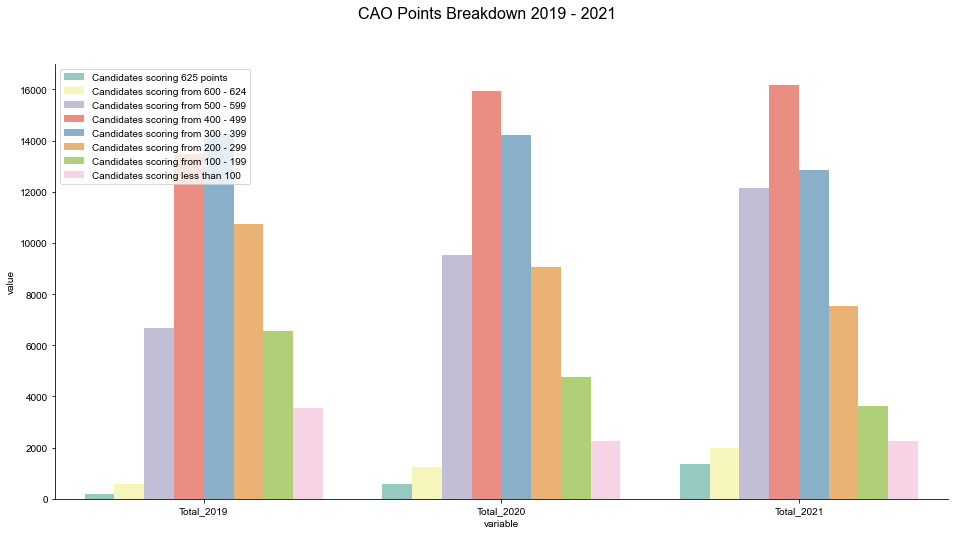

In [13]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

#Merging the 2019 - 21 points stats together
merge_1 = pd.merge(students_points_2021, students_points_2020, on = "Points_Range")
merge_2= pd.merge(merge_1, students_points_2019, on = "Points_Range")

#Making figure bigger to make room for legend
plt.rcParams['figure.figsize'] = [16, 8]

fig, ax = plt.subplots()

#Rearranging plots so the points values are all on the same column
student_points_melt = pd.melt(merge_2, id_vars=["Points_Range"], value_vars = ["Total_2019", "Total_2020", "Total_2021"])

#Removing comma from figures so they can be converted to int
student_points_melt['value']  = student_points_melt['value'].str.replace(",", "", regex = False)
student_points_melt["value"] = pd.to_numeric(student_points_melt["value"], downcast = "integer")
yr_order = ["Total_2019", "Total_2020", "Total_2021"]
sns.barplot(data = student_points_melt, x = "variable", y= "value", hue = "Points_Range", order = yr_order, palette = "Set3")
plt.legend(loc='upper left')
sns.despine()
plt.suptitle("CAO Points Breakdown 2019 - 2021", fontsize = 16)
sns.set_style("darkgrid")
plt.show()
plt.close()

As the plots illustrate,the number of students scoring >100 to 300 points has decreased steadily over the past three years and the proportion scoring 500 + has increased.

The points increase was most significant between 2020 and 2021, which may account for the rise in median and mean course values. 

### Distribution and Outliers

The below code generates barplots to show the overall points distribution for each of the three years. First the three dataframes from the previous section are merged together so they can be more easily represented on the same plot. Note that it's only possible to merge two dataframes together at a given time, hence the merge is completed in two steps. 

In [14]:
merge_points_1 = pd.merge(points2019, points2020, on = 'Course_Code')
merge_points_2 = pd.merge(merge_points_1, pointsData21, on = 'Course_Code')
merge_points_2 = merge_points_2.rename(columns = {"CATEGORY (i.e.ISCED description)" : "Course Category"})

#Removing duplicate columns
merge_points_2 = merge_points_2.drop(columns = ["Course Name_x", "Course Name_y"])
with pd.option_context('expand_frame_repr', False):
    #Sanity check to make sure DF merged properly
    print(merge_points_2[["Course_Code", "R1_Points19", "R2_Points19", "R1_Points20", "R2_Points20","R1_Points21", "R2_Points21"]].head())
    print("\n")

  Course_Code  R1_Points19  R2_Points19  R1_Points20  R2_Points20  R1_Points21  R2_Points21
0       AL801        304.0          NaN        303.0          NaN        300.0          NaN
1       AL802        301.0          NaN        332.0          NaN        313.0          NaN
2       AL803        309.0          NaN        337.0          NaN        350.0          NaN
3       AL805        329.0          NaN        333.0          NaN        321.0          NaN
4       AL810        307.0          NaN        319.0          NaN        328.0          NaN




The next step is to generate boxplots for R1 and R2 points data for each of the three years. 

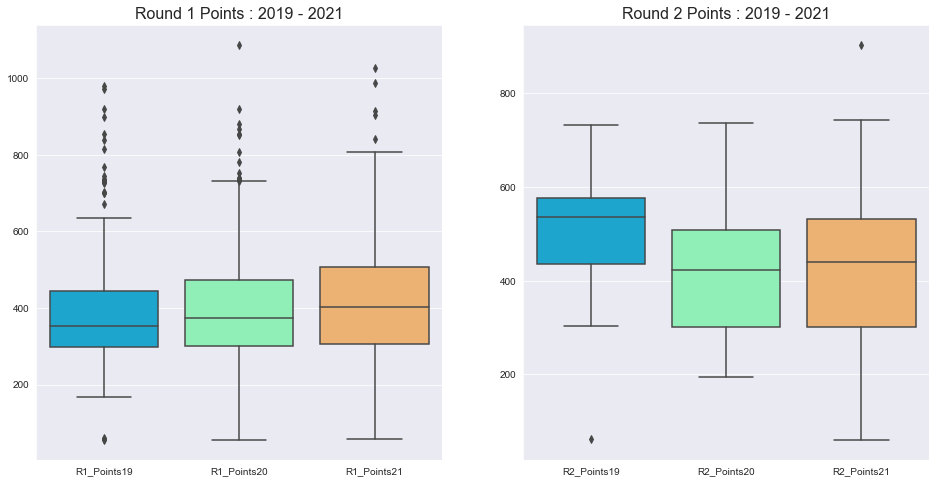

In [15]:
r1pointsonly = merge_points_2[["R1_Points19", "R1_Points20", "R1_Points21"]]
r2pointsonly = merge_points_2[["R2_Points19", "R2_Points20", "R2_Points21"]]

fig, (ax1, ax2) = plt.subplots(ncols = 2)
sns.boxplot(ax = ax1, data = r1pointsonly, palette = "rainbow")
ax1.set_title("Round 1 Points : 2019 - 2021", fontsize = 16)
ax2.set_title("Round 2 Points : 2019 - 2021", fontsize = 16)
sns.boxplot(ax = ax2, data = r2pointsonly, palette = "rainbow")
plt.show()

The box figures in the above plots represent the IQR (Interquartile Range) for the datasets:
- The lower end is the 25th percentile, the higher end is the 75th percentile, Q1 and Q3 respectively, and betwen these is the median (Q2)
- The whiskers represent the maximum and minimum values (Q3 + 1.5* IQR, Q3 + 1.5* IQR)
- The outliers (diamond shapes outside the plots) represent the remaining 0.7% of the dataset

The boxplots reveal the following details about the points datasets:
- Outliers are much more prevalent in the Round 1 points than in Round 2. These represent courses such as medicine, which factor the HPAT score into the points requirement, and certain art courses that also include a marked interview/portfolio as part of their entry process.
- As mentioned in the previous section, the median points value for Round 1 appears to increase each year from 2019- 2021. However, for Round 2 it appears to drop significantly from 2019 to 2021. 
- Additionally the IQR for 2019 is approximately 420 - 580, suggesting that Round 2 offers were mainly accepted for higher-point coures.
- However the IQR for both 2020 and 2021 are lower, suggesting that Round 2 offers were made and accepted for both higher and lower point courses. 

We could hypothesize from the above that the grade inflation of the previous two years meant that more students missed out on their desired course in the first round, and subsquently accepted a Round 2 offer. According to the [Irish Independent](https://www.independent.ie/irish-news/education/going-to-college/some-high-points-courses-see-big-drops-in-cao-round-2-40870000.html), this appears to have been the case, as several high-point courses dropped their requirements for Round 2, resulting in several students being offered their first preference. 

### 2. Popular Areas of Study and Trends

The next research question focuses on the most popular areas of study (e.g. Healthcare, IT, Arts, Business etc.) and how the points distribution within each of these areas has changed over the past three years. The aim is to determine the degree to which demand in these areas has fluctated between 2019 and 2021.

In addition to the course name, the 2020 CAO dataset included a broader course classification, e.g. Arts, Business and Administration, Engineering etc. This classification forms the basis for this analysis. Therefore, a limitation of these findings is that any courses that didn't feature in the 2020 offerings cannot be included. However, it should still give a relatively reliable indication of popular areas of study.

The Top 10 areas of study (based on numbers of courses offered within that area) are identified and plotted in a bar graph in the below code.

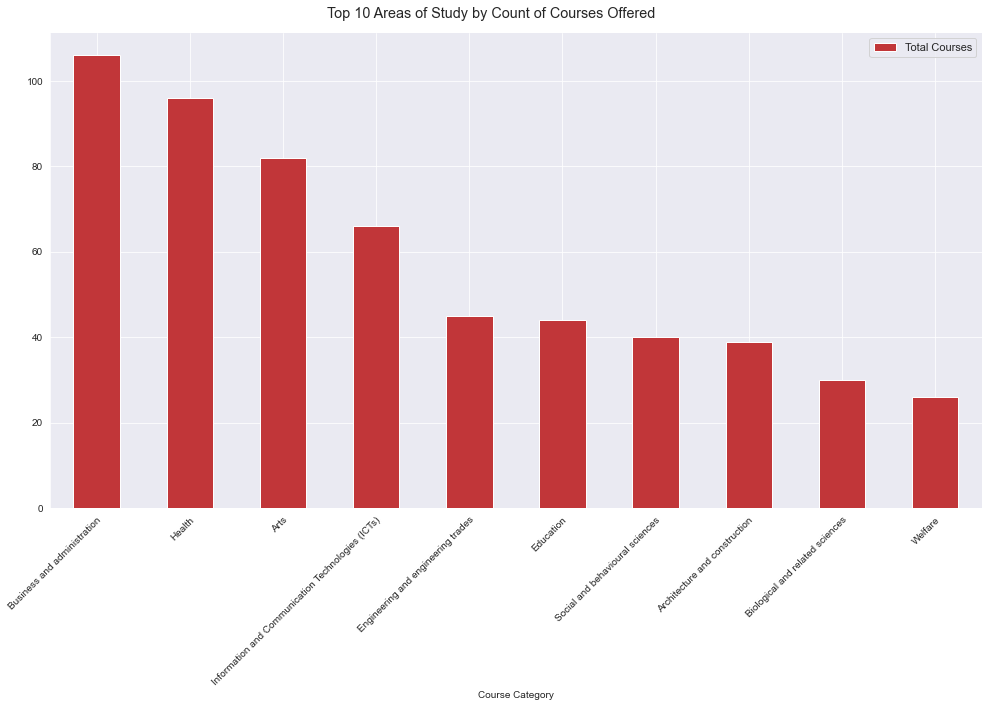

In [16]:
#Make plot bigger
fig, ax = plt.subplots(figsize=(14,10))
sns.set_theme(style='darkgrid', palette = "RdBu")
#Alignment parameters, will need this to rotate tick labels
ha = ['right', 'center', 'left']
#Initializing total column to store counts
merge_points_2["Total Courses"] = 1
#Group DF by course category then cound number of unique entries
course_categories = merge_points_2.groupby(["Course Category"])["Total Courses"].count()
#Convert the groupby object back to a df to make it easier to sort and plot
course_df = pd.DataFrame(course_categories, columns = ["Total Courses"])
#Sort in descending order by course category to get top 10
sorted_courses = course_df.sort_values(by = ["Total Courses"], ascending = False)
top_10_courses = sorted_courses.head(n = 10).plot(ax = ax, kind = "bar")
#Fix labels so they're not overlapping
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.suptitle("Top 10 Areas of Study by Count of Courses Offered")
plt.tight_layout()
plt.show()
plt.close()

We can see that the most popular areas of study include Business, Health, Arts, ICT and Engineering, with the highest total courses offered in these 5 disciplines. 

The next step is to filter on the top 5 areas of study for further analysis. The below code filters on the 5 highest counts using the head() function, then rearranges the dataframe so the points data from all three years are in the same column. Then violin plots are generated showing the distribution of points values within each of these areas for 2019, 2020 and 2021. 

#### R1 Points

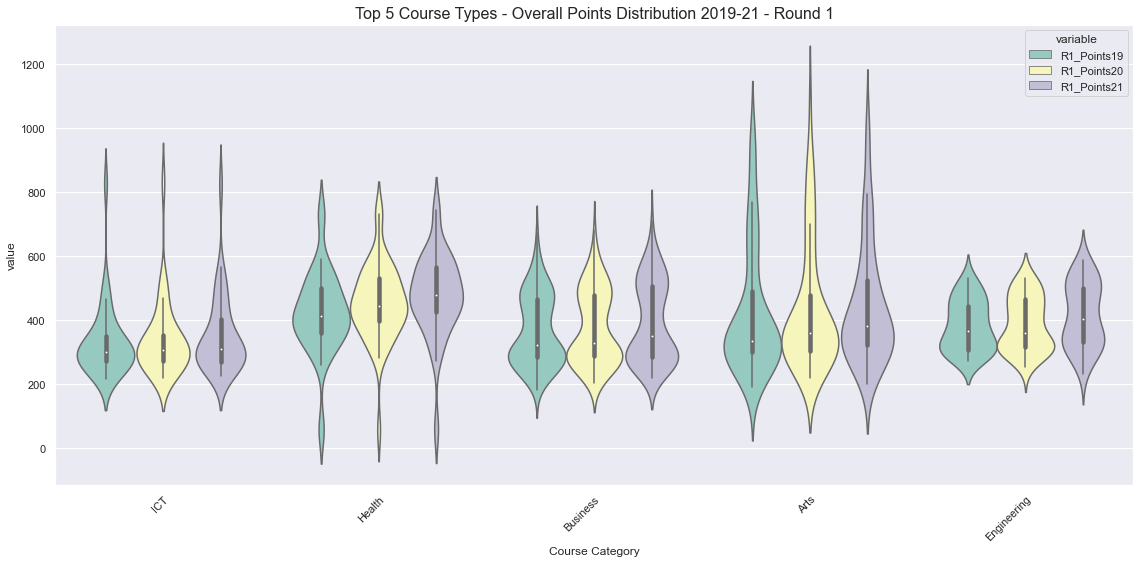

In [17]:
#Get the top 5 areas of study, then filter the original dataframe to get the points distribution for them
top_5_courses = sorted_courses.head(n = 5)
top_5_list = top_5_courses.index.tolist()
top_5_filter = merge_points_2["Course Category"].isin(top_5_list)
top_5_df = merge_points_2[top_5_filter]

fig, ax = plt.subplots()

#Melt dataframe so points values for all years are in same column
top_5_melt = top_5_df.melt(id_vars = ["Course Category"], value_vars= ["R1_Points19", "R1_Points20", "R1_Points21"])
sns.violinplot(data = top_5_melt, y = "value", x = "Course Category", hue = "variable", palette = "Set3")

#Tidy up x labels
xlabels =["ICT", "Health", "Business", "Arts", "Engineering"]
ax.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')

plt.title("Top 5 Course Types - Overall Points Distribution 2019-21 - Round 1", fontsize = 16)
plt.tight_layout()
sns.set_theme(style='darkgrid')

plt.show()
plt.close()

Violin plots are quite similar to boxplots, which were used in the previous section, except that they show, in addition to the IQR detail, the overall distribution of the dataset, which is particularly useful for data with multiple peaks (multimodal).

The above plots suggest the following about the five most popular areas of study:
 - The overall distribution of the points data for each does not appear to have changed significantly over the last three years, although the median values(represented by the white dot in the IQR bar) have increased in some areas, most notably Health, Arts and Engineering.
 - Aside from Health, the distributions for all the distributions peak at approximately 300-400. This supports the overall values for mean, mode and median obtained in the previous section. 
 - For ICT, \ the distribution is mainly concentrated around the peak, suggesting the majority of the courses are at around 300 points. 
- Arts also peaked at approximately 300 points, however the distribution is wider than ICT at each side of the peak. This indicates that a sizeable proportion of Arts courses are below 200 and above 400 points; the latter is predominantly due to courses including portfolios and interviews as part of the entry requirements. 
- In 2019 and 2020, Engineering points also peaked at approximately 300, but the shape above the peak is less narrow than Arts and ICT, suggesting that a significant proportion of courses in this area are between 400 and 600 points. In 2021, the distribution shifted towars a more bimodal shape, which may mean that points in Engineering subjects in general are increasing. 
- The bimodal shape is also present in the Business courses, although the peak at 300 is larger than the peak at 500. This suggests that although most business courses are about 300 points, several higher-point courses are also offered. 

### R2 Points

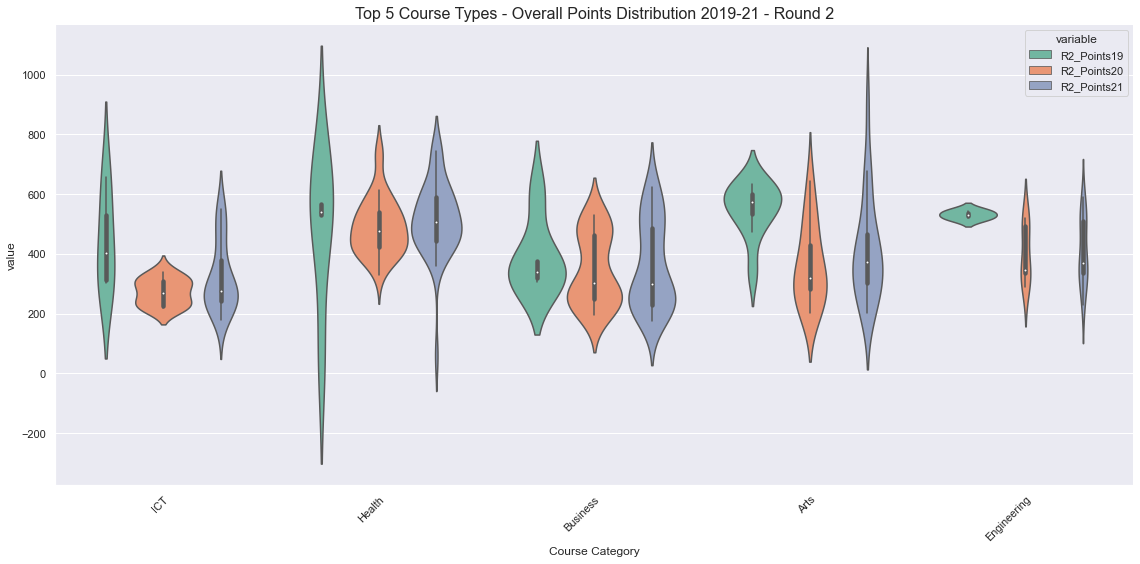

In [18]:
fig, ax = plt.subplots()

#Same code as previous plot, changing columns to Round 2 to compare the distributions
top_5_melt = top_5_df.melt(id_vars = ["Course Category"], value_vars= ["R2_Points19", "R2_Points20", "R2_Points21"])
sns.violinplot(data = top_5_melt, y = "value", x = "Course Category", hue = "variable", palette = "Set2")
xlabels =["ICT", "Health", "Business", "Arts", "Engineering"]
ax.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor')
plt.title("Top 5 Course Types - Overall Points Distribution 2019-21 - Round 2", fontsize = 16)
sns.despine()
plt.tight_layout()
plt.show()
plt.close()

- One notable feature of these plots is the lack of consistency in shape for each of the three years. For example, the distribution of ICT R2 points changes significantly each year. This is likely because the courses offered in R2, and by extension the distribution of the points, varies much more than those offered in R1.
- The IQR for most of the distributions is much smaller than their R1 equivalents. For several of the plots, only the median is depicted, suggesting that the dataset is too small to calculate an interquartile range. This may be because the number of courses offered in R2 is much smaller than that offered in R1.

To conclude, the distribution of points for the five most popular areas of study, based on total courses available, remains relatively consistent each year at Round 1. For the majority of disciplines, the probability distribution peaks at approximately 300, which is in line with the overall value obtained each year for mode. However, we can see that the median value for points has gradually increased each year, particularly in Engineering and Health. The distribution of Round 2 points appears to be more random, which is likely due to the variation each year in the courses offering Round 2 places.

#### 3.Universities vs Institutes of Technology (ITs)

The focus of this research question is the distribution of points values for Ireland's main universities and ITs, to determine the following:
- How do universities and ITs differ from each other in terms of level 8 points requirements?
- How has the distribution of points in ITs and universities changed over the last three years?

The below code uses the merged dataframe containing points values for 2019 - 2021. The HEI values are again obtained from the 2020 data.

First, the dataframe is filtered to include only courses  from the main Irish Universities and Institutes of Technology. The dataframe is melted to combine the 2019, 2020 and 2021 figures into one one column. Then barplots are generated to show the mean points value of courses from each institute. 

#### Universities

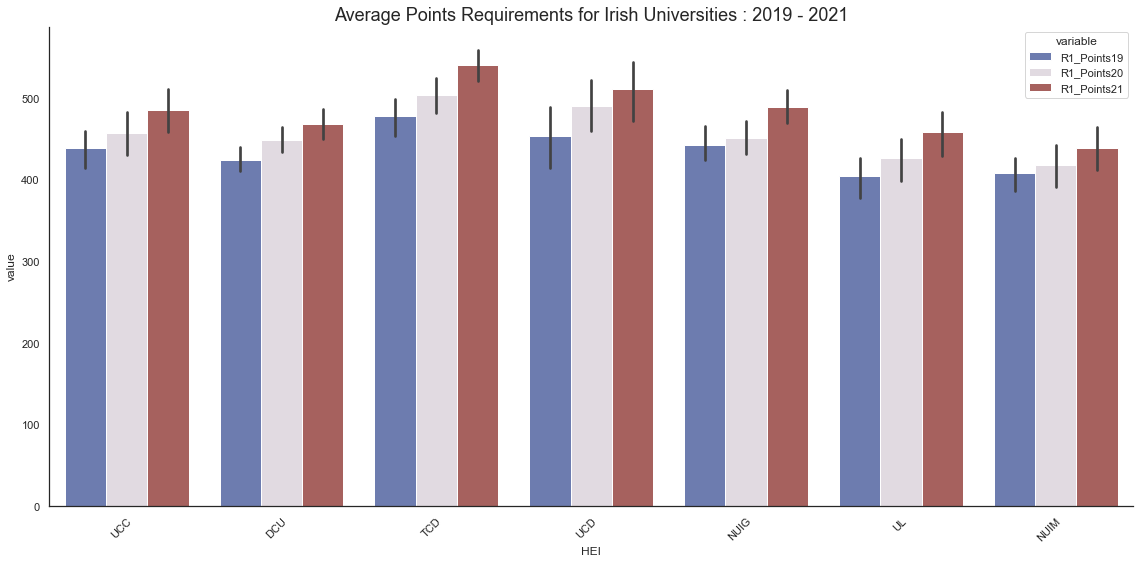

In [19]:
#University Plot
university_df = merge_points_2[merge_points_2["HEI"].isin(["Dublin City University", "Maynooth University", "Trinity College Dublin", "University College Cork (NUI)", "University College Dublin (NUI)", "University of Limerick", 'National University of Ireland, Galway'])]
university_melt = university_df.melt(id_vars = "HEI", value_vars= ["R1_Points19", "R1_Points20", "R1_Points21"])

sns.set_style("white")
fig, ax = plt.subplots()
sns.barplot(data = university_melt, x = "HEI", y = "value", hue = "variable", palette = "twilight_shifted")
xlabels = ["UCC", "DCU", "TCD", "UCD", "NUIG", "UL", "NUIM"]
ax.set_xticklabels(labels = xlabels, rotation=45, ha='right', rotation_mode='anchor')
plt.title("Average Points Requirements for Irish Universities : 2019 - 2021", fontsize = 18)
sns.despine()
plt.tight_layout()
plt.show()
plt.close()

Note that the black lines over the barplots indicate the confidence interval. When bar plots are generated using Seborn, the 95% confidence interval is calculated by the program, which is the range of values within which we can be 95% confident the true mean lies.

- Based on the above figure, the average points required for entry to every Irish university has increased progressively over the last three years. This may be due to an increase in the number of CAO applicants, or the rise in points achieved by students.  
- The confidence intervals for each university are small, suggesting the mean values shown in the plots are likely accurate.
- In general, the mean points value for university courses in 2021 is higher than the that of the whole dataset (407 points), suggesting a strong competition for places in these institutes.
- Trinity College Dublin has the highest average point requirements of the above universities. In 2021 the mean points required for entry to TCD was over 500, meaning most of its courses are open to approximately a quarter of the students that sat the Leaving Cert this year. UCD, UCC and NUIG are also approaching this value. 


#### ITs

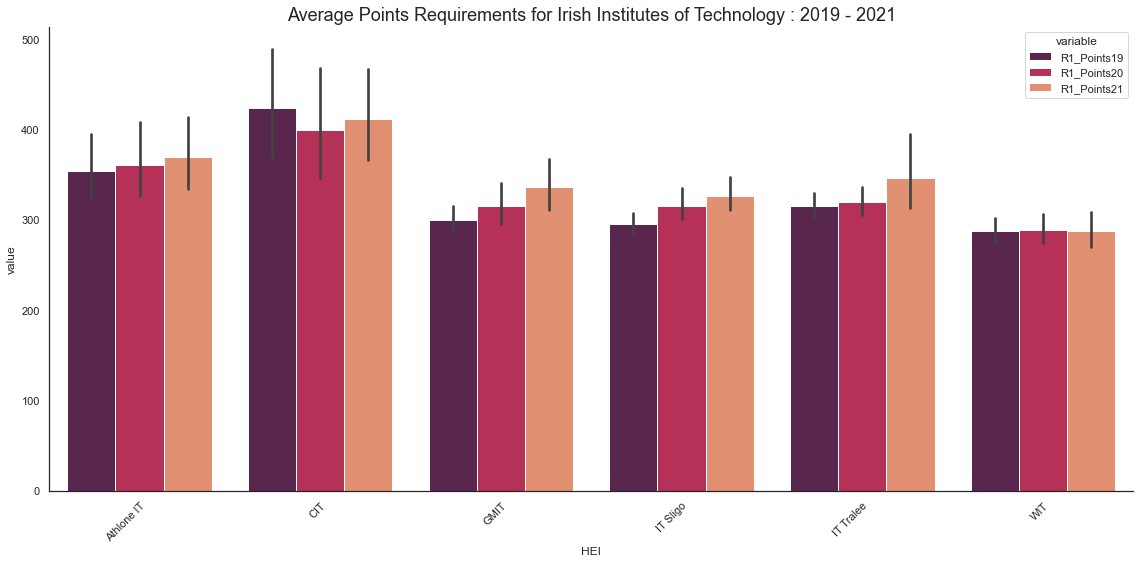

In [20]:
it_df = merge_points_2[merge_points_2["HEI"].isin(["Athlone Institute of Technology", "Cork Institute of Technology", "Galway-Mayo Institute of Technology", "Institute of Technology, Sligo", "Institute of Technology, Tralee", "Waterford Institute of Technology"])]
it_melt = it_df.melt(id_vars = "HEI", value_vars= ["R1_Points19", "R1_Points20", "R1_Points21"])

fig, ax = plt.subplots()
sns.barplot(data = it_melt, x = "HEI", y = "value", hue = "variable", palette = "rocket")
plt.title("Average Points Requirements for Irish Institutes of Technology : 2019 - 2021", fontsize = 18)
xlabels = ["Athlone IT", "CIT", "GMIT", "IT Sligo", "IT Tralee", "WIT"]
ax.set_xticklabels (labels = xlabels, rotation=45, ha='right', rotation_mode='anchor')
sns.despine()
plt.tight_layout()
plt.show()
plt.close()

- The average points required for entry to Institutes of Technology is significantly lower than that of universities. Aside from CIT, the mean points value for each of the above ITs is between 300 and 400. 
- However, the mean points required for IT courses is also increasing. Aside from WIT and CIT, the mean points have increased every year for each institute, and in CIT the average points requirement increased between 2020 and 2021. 
- The confidence intervals for CIT are significantly larger than those seen for the other institutes. This may be because CIT has associated arts and music schools. Many of these courses use a combination of CAO points and interview/portfolio results, resulting in a very high (600-800) point figure, which may be skewing the dataset.  

In summary, the points required for entry to Level 8 courses appears to be increasing at both universities and institutes of technology, likely a reflection of the higher grades achieved by students. 

#### 3.High and Low Point Trends

The aim of this research question is to address the following:
- What were the highest and lowest-point courses for each of the three years?
- For the highest and lowest point courses in 2019, how did these fluctuate over the next 10 years?

#### Highest Point Courses

The below function is used to retrieve and print the courses with the highest and lowest point values each year by sorting the dataframe in descending or ascending order.

It takes the following parameters:
- df: dataframe containing course information
- column: column on which to sort the values
- lowhigh: boolean - when True sort the values in ascending order (lowest point courses), when False sort in descending order (highest point courses)

In [30]:
def course_trends2(df, col, yr, lowhigh):
    if lowhigh == False:
        trend = "Top"
    else:
        trend = "Bottom"

    pd.set_option('display.max_columns', 500)

    points_df =  df.sort_values(col, ascending = lowhigh).head(10)
    points_df.style.hide_columns(["Course Category"])
    with pd.option_context('expand_frame_repr', False):
        print("\n")
        print("{0} 10 Courses : {1}".format(trend, yr))
        print("\n")
        print (points_df[["Course_Code", "Course_Name", col]])
        return points_df[["Course_Code", "Course_Name", col]]      

When this function was applied to the dataset as a whole, the 10 highest courses each year were Undergraduate Entry Medicine and Art courses that also included portfolio/interview scores, and the lowest were Graduate Entry Medicine. Even though applications for this course are managed through the CAO, the assessment process is different to traditional Level 8 programmes.

Therefore, the below code filters out all courses that are over 625 points, or contain "portfolio" or "art" in the course name, to leave courses that base point requirements on Leaving Cert results only. 

In [22]:
exclude_arts = merge_points_2[(merge_points_2["R1_Points19"] <= 625.00) & (merge_points_2["R1_Points20"] < 625.00) & (merge_points_2["R1_Points21"] <= 625.00)]
exclude_arts = exclude_arts[(exclude_arts["Course_Name"].str.contains("portfolio") == False) & (exclude_arts["Course_Name"].str.contains("Art") == False)]

top_2019 = course_trends2(df = exclude_arts, col = "R1_Points19", yr = "2019", lowhigh = False)



Top 10 Courses : 2019


    Course_Code                                        Course_Name  R1_Points19
372       DN670                              Economics and Finance        601.0
144       CK702                                          Dentistry        590.0
317       TR052                                     Dental Science        590.0
311       TR034  Management Science and Information Systems Stu...        589.0
200       DC116                              Global Business (USA)        578.0
145       CK703                                           Pharmacy        577.0
347       DN230                    Actuarial and Financial Studies        577.0
351       DN300          Veterinary Medicine - Undergraduate Entry        567.0
298       TR015  Philosophy  Political Science  Economics and S...        566.0
308       TR031                                        Mathematics        566.0


In [23]:
top_2020 = course_trends2(df = exclude_arts, col = "R1_Points20", yr = "2020", lowhigh = False)



Top 10 Courses : 2020


    Course_Code                                        Course_Name  R1_Points20
317       TR052                                     Dental Science        613.0
144       CK702                                          Dentistry        613.0
372       DN670                              Economics and Finance        613.0
311       TR034  Management Science and Information Systems Stu...        613.0
347       DN230                    Actuarial and Financial Studies        601.0
145       CK703                                           Pharmacy        590.0
326       TR072                                           Pharmacy        590.0
598       LM100                                      Physiotherapy        589.0
327       TR080                                    Global Business        589.0
351       DN300          Veterinary Medicine - Undergraduate Entry        589.0


In [24]:
top_2021 = course_trends2(df = exclude_arts, col = "R1_Points21", yr = "2021", lowhigh = False)



Top 10 Courses : 2021


    Course_Code                                        Course_Name  R1_Points21
317       TR052                                     Dental Science        625.0
372       DN670                              Economics and Finance        625.0
311       TR034  Management Science and Information Systems Stu...        625.0
144       CK702                                          Dentistry        625.0
298       TR015  Philosophy  Political Science  Economics and S...        613.0
598       LM100                                      Physiotherapy        613.0
327       TR080                                    Global Business        613.0
347       DN230                    Actuarial and Financial Studies        613.0
289       RC005                                           Pharmacy        613.0
473       GY303                                 Biomedical Science        613.0


- Based on the above figures, certain courses appear to be consistently popular, such as Dentistry, Global Business, Pharmacy and Actuarial and Financial studies.
- The Dublin-based universities (TCD, UCD and DCU) feature heavily in the top 10 course list each year. For universities from other parts of Ireland, such as UCC, GMIT and UL, only medical courses are included in the list, suggesting that Dublin is the most desirable destination for students.
- The grade inflation that has taken place over the last three years is also evident in these lists. In 2019, only one course in the list was over 600 points. In 2020 this had increased to five, and in 2021 all courses in the top ten list was over 600. Furthermore, 4 courses in the list were 625 points, meaning students required a perfect Leaving Cert score to gain entry. 

The below function takes the top 10 courses in 2019 and examines how they have fluctuated over the last two years. It is expected, based on observations made to date in this dataset, that the points for each of the courses will have increased. 

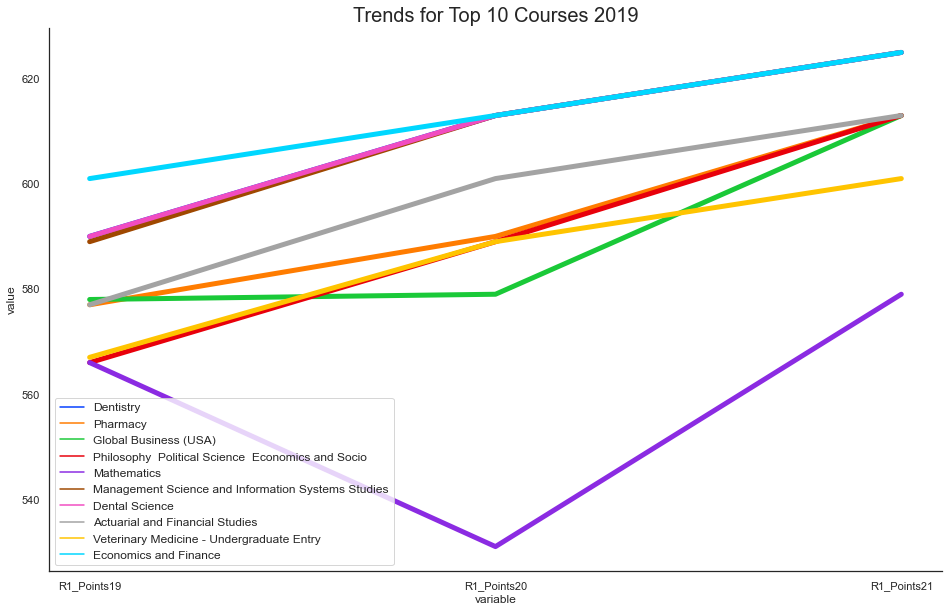

In [25]:
top_courses = top_2019["Course_Code"].tolist()
top_course_filter = merge_points_2["Course_Code"].isin(top_courses)
top_course_df = merge_points_2[top_course_filter]

def course_plot(df, x):
    top_2019_melt = df.melt(id_vars = "Course_Name", value_vars= ["R1_Points19", "R1_Points20", "R1_Points21"])
    sns.set_style("white")
    fig, ax = plt.subplots(figsize =(16,10))
    sns.lineplot(data = top_2019_melt, x= "variable", y = "value", hue = "Course_Name", palette = "bright", linewidth = 5)
    ax.set_title("Trends for {} 10 Courses 2019".format(x), fontsize = 20)
    plt.legend(fontsize = "medium")
    sns.despine()
    plt.show()
    plt.close()
    
course_plot(df = top_course_df, x = "Top")

- As expected, the points required for 2019's top 10 courses increased again in 2020 and 2021. Two courses decreased between 2019 and 2020, Mathematics at TCD and Global Business (USA) at DCU, however both increased again in 2021.
- The highest point course in 2019 was Economics and Finance at UCD, followed by Dentistry at UCC and Dental Science at TCD. By 2021, these courses had all increased to 625 points, along with MSISS at TCD. 
- Of these 10 courses, 7 also feature in the top 10 courses for 2021. Mathematics at TCD and Veterinary Medicine were supplanted by other courses as they both were under 600 points in 2021. Global Business (USA) is also absent from the top 10 list in 2021, despite having the same points requirement in 2021 as two other courses that included in the list. Therefore, there were more than ten courses in 2021 requiring a score over over 600 points. 

In summary, the requirements for the high-point courses have increased significantly between 2019 and 2021. In particular, the number of courses requiring over 600 points has increased from 1 in 2019 to more than 10 in 2021, which must be related to the increased number of candidates scoring over 600 in this year's Leaving Cert. 

#### Lowest Point Courses

In the below cells, the functions from the previous section are re-used to determine the 10 lowest-point courses for each year.

As noted already, the dataset was filtered to remove Graduate Entry Medicine. 

In [31]:
exclude_med = merge_points_2[~merge_points_2["Course_Name"].str.contains("Medicine")]
bottom_10_2019 = course_trends2(df = exclude_med, col = "R1_Points19", yr = "2019", lowhigh = True)



Bottom 10 Courses : 2019


    Course_Code                                        Course_Name  R1_Points19
59        PC411  English and History (fulfils Teaching Council ...        168.0
260       GC401                             Accounting and Finance        181.0
182       DB567                            Film and Creative Media        192.0
58        PC410  Arts and Humanities (fulfils Teaching Council ...        203.0
180       DB562                                         Psychology        208.0
243       DL822                                    Arts Management        209.0
565       LC402                                   Social Care Work        209.0
436       GA885                                  Outdoor Education        210.0
711       WD091                             Hospitality Management        210.0
533       LC226                          Enterprise and Innovation        216.0


In [32]:
bottom_10_2020 = course_trends2(df = exclude_med, col = "R1_Points20", yr = "2020", lowhigh = True)



Bottom 10 Courses : 2020


    Course_Code                       Course_Name  R1_Points20
251       DL837                 New Media Studies        201.0
268       ID001            Accounting and Finance        203.0
411       GA382  Culinary and Gastronomic Science        206.0
156       AC120            International Business        209.0
723       WD162                Quantity Surveying        216.0
730       WD194                     Culinary Arts        217.0
182       DB567           Film and Creative Media        218.0
165       DB500                         Computing        218.0
171       DB512                  Business Studies        218.0
183       DB568                               Law        219.0


In [33]:
bottom_10_2021 = course_trends2(df = exclude_med, col = "R1_Points21", yr = "2021", lowhigh = True)



Bottom 10 Courses : 2021


    Course_Code                                    Course_Name  R1_Points21
437       GA887                          History and Geography        201.0
732       WD200                                 Arts (options)        201.0
516       MI001       Contemporary and Applied Theatre Studies        209.0
170       DB510  Audio Production and Music Project Management        217.0
409       GA380                 International Hotel Management        218.0
244       DL823                            Business Management        220.0
264       GC450            Communications and Media Production        225.0
711       WD091                         Hospitality Management        225.0
535       LC234  Immersive Digital Media and Spatial Computing        226.0
723       WD162                             Quantity Surveying        226.0


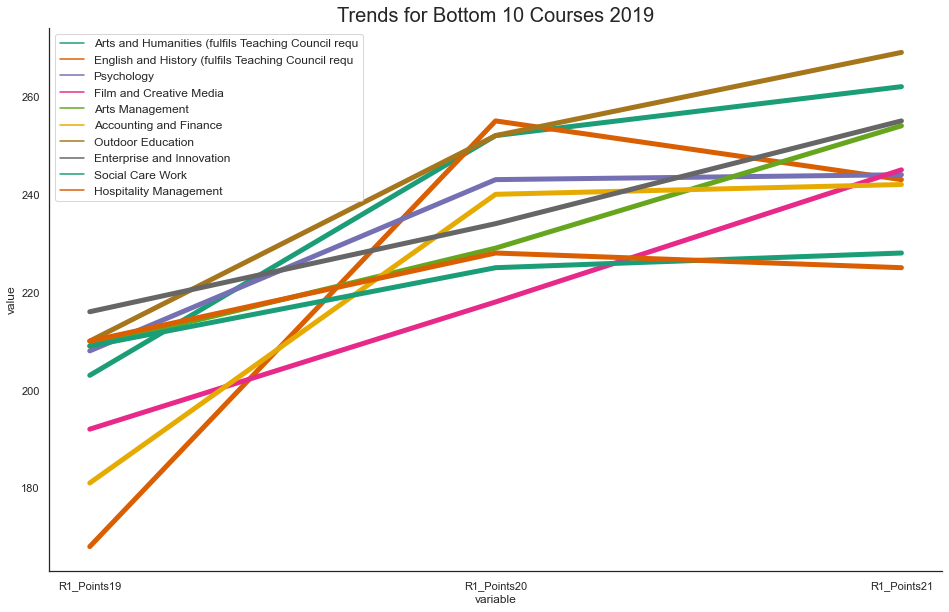

In [39]:
bottom_courses = bottom_10_2019["Course_Code"].tolist()
bottom_course_filter = merge_points_2["Course_Code"].isin(bottom_courses)
bottom_course_df = merge_points_2[bottom_course_filter]
  
course_plot(df = bottom_course_df, x = "Bottom")

This output provides the following insight into courses at the lower end of the points scale:
- The 10 lowest point courses fluctuate much more than the courses with the highest point requirements. While the latter has stayed relatively consistent over the past three years, the former appears to change almost completely each year. This may be because lower point courses outnumber those with higher points, as evidenced by the distributions produced in Section 1 of this notebook.
- For each year, the bottom 10 courses are significantly lower than the average overall figure (Section 1). However, we can see that the points are still increasing at this end of the spectrum. In 2019, three courses were under 200 points. In 2020/21, the minimum points value for any course was 201. 
- The majority of courses in this list for each year were in the Arts and Humanities fields, which helps explain the wide variation observed in the points distribution for Arts courses (Section 2). 
- While the top 10 courses were predominantly offered by Dublin universities, most of these courses are from smaller colleges such as Dublin Business School and Carlow College, or ITs based outside Dublin such as GMIT and WIT. 

## Conclusion

This notebook extracts data in various formats from the CAO website on points required for entry to Level 8 courses, converts them to Pandas dataframes, and using various Python libraries, discusses points trends over the last three years.

Below are the key observations from this analysis:
- The average points required for entry to Level 8 courses increased significantly in 2021, likely in tandem with the higher grades achieved by Leaving Certificate students this year.
- Although the median and mean increased, the mode (300) remained the same, suggesting that 300 is the most common points value for an individual course. 
- The boxplots showing the distribution of R2 points for courses showed more variation for 2021 than the previous two years. This may be due to several high-point courses dramatically dropping their points for the second round, which likely led to more student than usual accepting R2 offers.
- The five most popular areas of study, based on number of courses offered in each discipline, are Business, ICT, Arts, Health and Engineering. Although the distribution of Round 1 point values for these areas remained relatively consistent over the three years, the median values have increased, particularly for Engineering and Health. 
- Points required for entry to most universities is significantly higher than the average points value for all courses. This is particularly true of the larger Dublin-based universities. 
- Points required for entry to institutes of technology is lower than those for universities. However, the points required to gain entry to both universities and ITs is increasing each year.
- The ten highest point courses are typically offered by TCD/UCD/other major universities, and the main disciplines represented are Finance/Mathematics, Economics, Business, and Medicine, particularly Dentistry.
- The number of courses requiring over 600 points has increased dramatically between 2019 and 2021. This is likely because there has been a five - fold increase in the number of students achieving 600 or more points during this time.
- At the opposite end of the spectrum, the points required is also increasing. In 2019, there were 3 courses requiring less than 200 points, in 2020/21 there were none.

In summary, the approach taken to assessing students in 2021 due to Covid-19 has resulted in more students achieving higher points, which has in turn driven up the points for most level 8 courses. 